<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C6/C6.html"><img src="../data/C6_nav.png" width="100"  style="float:right;" alt="C6"></a>
<h1>Novelty: Comparison of Approaches</h1> 
</div>

<br/>

<p>
In this notebook, we compare different approaches for computing novelty functions, see Section 6.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. An overview of onset detection methods can also be found in the following articles:
     
<ul>
<li><span style="color:black">
Juan Pablo Bello, Laurent Daudet, Samer A. Abdallah, Chris Duxbury, Mike E. Davies, and Mark B. Sandler: <strong>A Tutorial on Onset Detection in Music Signals.</strong> IEEE Transaction on Speech and Audio Processing 13(5-2), 2005, pp. 1035&ndash;1047.   
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_BelloDADDS05_OnsetTutorial_IEEE-TSA.txt"> Bibtex </a>
</span></li>
    <li><span style="color:black">
Simon Dixon: <strong>Onset Detection Revisited.</strong> Proceedings of the International Conference on Digital Audio Effects (DAFx), 2006, pp. 133&ndash;137.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_Dixon06_OnsetDection_DAFx.txt"> Bibtex </a>
</span></li>
</ul>   
</p> 

## Approaches for Novelty Computation

In the previous notebooks, we introduced four different approaches for computing a novelty function: 

* [Energy-based novelty approach](../C6/C6S1_NoveltyEnergy.html)
* [Spectral-based novelty approach](../C6/C6S1_NoveltySpectral.html) 
* [Phase-based novelty approach](../C6/C6S1_NoveltyPhase.html)
* [Complex-domain novelty approach](../C6/C6S1_NoveltyComplex.html) 

All approaches go along with a number of parameters and may be combined with suitable post-processing strategies. Using the default parameter settings of `LibFMP`, we compare the four approaches with the excerpt of "Another one bites the dust" by Queen as introduced in the [FMP notebook on onset detection](../C6/C6S1_OnsetDetection.html).

<img src="../data/C6/FMP_C6_F01a.png" width="350px" align="left" alt="FMP_C6_F01.png">

<br clear="all" />

<audio style="width: 320px;" src="../data/C6/FMP_C6_F01_Queen.mp3" type="audio/mpeg" controls="controls"></audio>


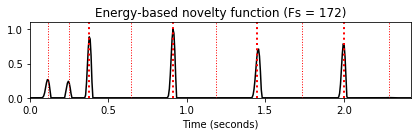

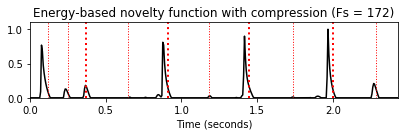

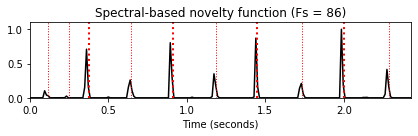

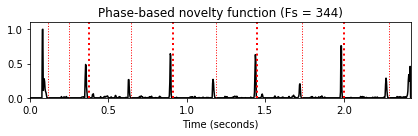

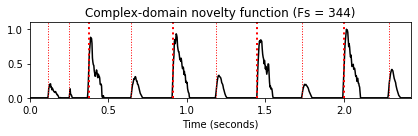

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from scipy.interpolate import interp1d
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd


sys.path.append('..')
import LibFMP.B
import LibFMP.C2
import LibFMP.C6

%matplotlib inline


fn_ann = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.csv')
ann, label_keys = LibFMP.C6.read_annotation_pos(fn_ann)

fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs)
x_duration = len(x)/Fs

nov_dic = {}

nov, Fs_nov = LibFMP.C6.compute_novelty_energy(x, Fs=Fs, gamma=None)
nov_dic.update( {0 : [nov, Fs_nov, r'Energy-based novelty function (Fs = %d)'%Fs_nov]} )

nov, Fs_nov = LibFMP.C6.compute_novelty_energy(x, Fs=Fs, gamma=1000)
nov_dic.update( {1 : [nov, Fs_nov, 'Energy-based novelty function with compression (Fs = %d)'%Fs_nov]} )

nov, Fs_nov = LibFMP.C6.compute_novelty_spectrum(x, Fs=Fs)
nov_dic.update( {2 : [nov, Fs_nov, 'Spectral-based novelty function (Fs = %d)'%Fs_nov]} )

nov, Fs_nov = LibFMP.C6.compute_novelty_phase(x, Fs=Fs)
nov_dic.update( {3 : [nov, Fs_nov, 'Phase-based novelty function (Fs = %d)'%Fs_nov]} )

nov, Fs_nov = LibFMP.C6.compute_novelty_complex(x, Fs=Fs)
nov_dic.update( {4 : [nov, Fs_nov, 'Complex-domain novelty function (Fs = %d)'%Fs_nov]} )

for k in nov_dic:
    fig, ax, line = LibFMP.B.plot_signal(nov_dic[k][0], Fs=nov_dic[k][1], 
                        color='k', title=nov_dic[k][2])
    LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                nontime_axis=True, time_min=0, time_max=x_duration)    

## Time Axis Resampling

The different approaches may lead to novelty functions with different features rates. To directly compare or even combine these novelty functions, we now introduce a **resampling approach** for adjusting the feature rate. More generally, the approach transforms an input signal with a given feature rate (`Fs_in`) into another signal with a given target frame rate (`Fs_out`) using [**linear interpolation**](../C2/C2_STFT-FreqGridInterpol.html). As an example, this function is then apply to convert the complex-domain novelty function (with a feature rate of $344.531~\mathrm{Hz}$) into a novelty function with a target feature of $100~\mathrm{Hz}$.

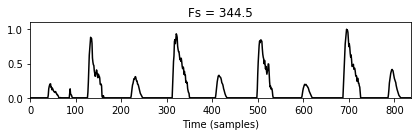

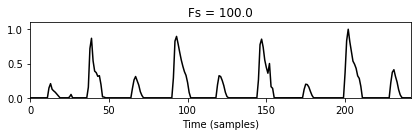

In [2]:
def resample_signal(x_in, Fs_in, Fs_out=100, norm=1, time_max_sec=None, sigma=None):
    """Resample and smooth signal

    Notebook: C6/C6S1_NoveltyComparison.ipynb

    Args:
        x_in: Input signal
        Fs_in: Sampling rate of input signal 
        Fs_out: Sampling rate of output signal 
        norm: Apply max norm (if norm==1)
        time_max_sec: Duration of output signal (given in seconds)
        sigma: Standard deviation for smoothing Gaussian kernel

    Returns:
        x_out: Output signal
        F_out: Feature rate of output signal
    """    
    if sigma is not None:
        x_in = ndimage.gaussian_filter(x_in, sigma=sigma)
    T_coef_in = np.arange(x_in.shape[0]) / Fs_in
    time_in_max_sec = T_coef_in[-1]
    if time_max_sec is None:
        time_max_sec = time_in_max_sec
    N_out = int(np.ceil(time_max_sec*Fs_out))
    T_coef_out = np.arange(N_out) / Fs_out     
    if T_coef_out[-1] > time_in_max_sec:
        x_in = np.append(x_in, [0])
        T_coef_in = np.append(T_coef_in, [T_coef_out[-1]])    
    x_out = interp1d(T_coef_in, x_in, kind='linear')(T_coef_out)
    if norm==1:
        x_max = max(x_out) 
        if x_max > 0:
            x_out = x_out / max(x_out)    
    return x_out, Fs_out

nov, Fs_nov = LibFMP.C6.compute_novelty_complex(x, Fs)
LibFMP.B.plot_signal(nov, Fs=1, xlabel='Time (samples)', color='k', 
        title='Fs = %0.1f'%Fs_nov);

nov_out, Fs_out = resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)
LibFMP.B.plot_signal(nov_out, Fs=1, xlabel='Time (samples)', color='k',
        title='Fs = %0.1f'%Fs_out);

Reducing the feature rate via **linear interpolation** may be problematic in cases where a novelty function has peak-like structures that are strongly localized in time. In such cases, the peak may be attenuated by the resampling approach. This is demonstrated by the following example, which shows the phase-based novelty function. One possible strategy to better preserve the peak structure is to apply a **smoothing filter** prior to the resampling (at the cost of smearing the temporal localization).

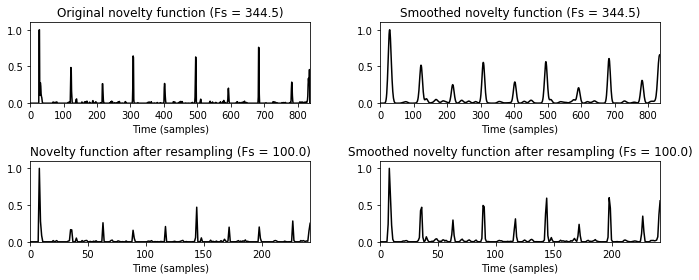

In [3]:
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1,1], 'height_ratios': [1,1]}, 
                       figsize=(10,4))

nov, Fs_nov = LibFMP.C6.compute_novelty_phase(x, Fs)
LibFMP.B.plot_signal(nov, Fs=1, ax=ax[0,0], xlabel='Time (samples)', color='k', 
        title='Original novelty function (Fs = %0.1f)'%Fs_nov)

nov_out, Fs_out = resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)
LibFMP.B.plot_signal(nov_out, ax=ax[1,0], Fs=1, xlabel='Time (samples)', color='k', 
        title='Novelty function after resampling (Fs = %0.1f)'%Fs_out);

Fs_out = Fs_nov
nov_smooth, Fs_out = resample_signal(nov, Fs_in=Fs_nov, Fs_out=Fs_out, sigma=4)
LibFMP.B.plot_signal(nov_smooth, Fs=1, ax=ax[0,1], xlabel='Time (samples)', color='k', 
        title='Smoothed novelty function (Fs = %0.1f)'%Fs_nov)

Fs_out = 100
nov_smooth_out, Fs_out = resample_signal(nov, Fs_in=Fs_nov, Fs_out=Fs_out, sigma=2)
LibFMP.B.plot_signal(nov_smooth_out, ax=ax[1,1], Fs=1, xlabel='Time (samples)', color='k', 
        title='Smoothed novelty function after resampling (Fs = %0.1f)'%Fs_out);

plt.tight_layout()

## Matrix-Based Visualization and Averaging 

After converting different novelty function to a common discrete time axis, one can easily visualize these functions in a color-coded form. This is demonstrated by the following example, which shows five different novelty functions (as shown above) as well as the average of these functions. 

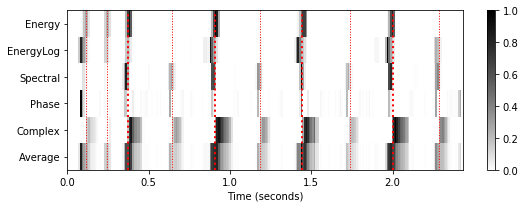

In [4]:
def average_nov_dic(nov_dic, time_max_sec, Fs_out=100, norm=1, sigma=None):
    """Average respamples set of novelty functions

    Notebook: C6/C6S1_NoveltyComparison.ipynb

    Args:
        nov_dic: Dictionary of novelty functions
        time_max_sec: Duration of output signals (given in seconds)
        Fs_out: Sampling rate of output signal 
        norm: Apply max norm (if norm==1)
        sigma: Standard deviation for smoothing Gaussian kernel

    Returns:
        nov_matrix: Matrix containing resampled output signal (last one is average)
        Fs_out: Sampling rate of output signals 
    """       
    nov_num = len(nov_dic)
    N_out = int(np.ceil(time_max_sec*Fs_out))    
    nov_matrix = np.zeros([nov_num + 1, N_out])
    for k in range(nov_num):
        nov = nov_dic[k][0]
        Fs_nov = nov_dic[k][1]
        nov_out, Fs_out = resample_signal(nov, Fs_in=Fs_nov, Fs_out=Fs_out, 
                                  time_max_sec=x_duration, sigma=sigma)        
        nov_matrix[k,:] = nov_out
    nov_average = np.sum(nov_matrix, axis=0)/nov_num
    if norm==1:
        max_value = np.max(nov_average)
        if max_value > 0:
            nov_average = nov_average / max_value        
    nov_matrix[k+1,:] = nov_average
    return nov_matrix, Fs_out 

cmap = LibFMP.B.compressed_gray_cmap(alpha=1)
Fs_out = 100
nov_matrix, Fs_out = average_nov_dic(nov_dic, time_max_sec=x_duration, Fs_out=Fs_out)

plt.figure(figsize=[8,3])
ax = plt.subplot(1,1,1)
im = ax.imshow(nov_matrix, cmap=cmap, aspect='auto', clim=[0,1],
          extent=[0, x_duration, nov_matrix.shape[0]+0.5, 0.5])
ax.set_xlabel('Time (seconds)')
ax.set_yticks([1,2,3,4,5,6])
ax.set_yticklabels([r'Energy', r'EnergyLog', r'Spectral', r'Phase', r'Complex', r'Average'])
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.colorbar(im)
plt.tight_layout()

As discussed above, it may be beneficial to apply apply a **smoothing filter** prior to the resampling a novelty curve. Furthermore, smoothing also makes the averaging less vulnerable to small temporal deviations across different novelty functions. A similar smoothing strategy is used prior to differentiation (see the [FMP notebook on structure features](../C4/C4S4_StructureFeature.html)) and prior to applying harmonic summation (see the [FMP notebook on salience representations](../C8/C8S2_SalienceRepresentation.html)). The effect of smoothing is illustrated by the next figure. 

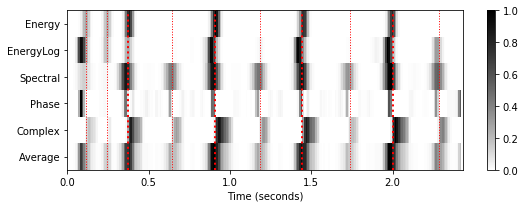

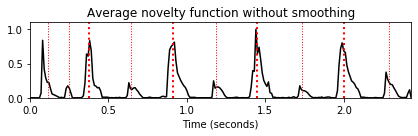

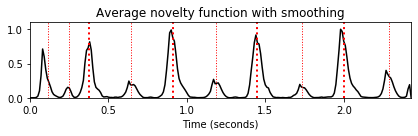

In [5]:
Fs_out = 100
sigma = 2
nov_matrix_smooth, Fs_out = average_nov_dic(nov_dic, time_max_sec=x_duration, 
                                            Fs_out=Fs_out, sigma=sigma)

plt.figure(figsize=[8,3])
ax = plt.subplot(1,1,1)
im = ax.imshow(nov_matrix_smooth, cmap=cmap, aspect='auto', clim=[0,1],
          extent=[0, x_duration, nov_matrix.shape[0]+0.5, 0.5])
ax.set_xlabel('Time (seconds)')
ax.set_yticks([1,2,3,4,5,6])
ax.set_yticklabels([r'Energy', r'EnergyLog', r'Spectral', r'Phase', r'Complex', r'Average'])
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.colorbar(im)
plt.tight_layout()

fig, ax, line = LibFMP.B.plot_signal(nov_matrix[-1,:], Fs=Fs_out, 
                        color='k', title='Average novelty function without smoothing')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                nontime_axis=True, time_min=0, time_max=x_duration)    

fig, ax, line = LibFMP.B.plot_signal(nov_matrix_smooth[-1,:], Fs=Fs_out, 
                        color='k', title='Average novelty function with smoothing')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                nontime_axis=True, time_min=0, time_max=x_duration);

## Example: Note C4

As second example, we consider the note $\mathrm{C}4$ played by different instruments (piano, trumpet, violin, flute). While most novelty functions show a prominent peak in the case of a piano sound, there are less prominent peaks and many additional spurious peaks in the case of the other instruments (see also our discussion in the [FMP notebook on onset detection](../C6/C6S1_OnsetDetection.html)). 

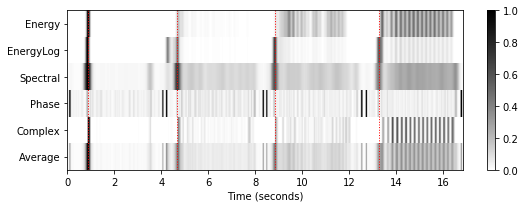

In [6]:
fn_ann = os.path.join('..', 'data', 'C6', 'FMP_C6_F04_NoteC4_PTVF.csv')
ann, label_keys = LibFMP.C6.read_annotation_pos(fn_ann, label='onset', header=0)

fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F04_NoteC4_PTVF.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs)
x_duration = len(x)/Fs

nov_dic = {}

nov, Fs_nov = LibFMP.C6.compute_novelty_energy(x, Fs=Fs, gamma=None)
nov_dic.update( {0 : [nov, Fs_nov, 'Energy-based novelty function']} )

nov, Fs_nov = LibFMP.C6.compute_novelty_energy(x, Fs=Fs, gamma=1000)
nov_dic.update( {1 : [nov, Fs_nov, 'Energy-based novelty function with compression']} )

nov, Fs_nov = LibFMP.C6.compute_novelty_spectrum(x, Fs=Fs)
nov_dic.update( {2 : [nov, Fs_nov, 'Spectral-based novelty function']} )

nov, Fs_nov = LibFMP.C6.compute_novelty_phase(x, Fs=Fs)
nov_dic.update( {3 : [nov, Fs_nov, 'Phase-based novelty function']} )

nov, Fs_nov = LibFMP.C6.compute_novelty_complex(x, Fs=Fs)
nov_dic.update( {4 : [nov, Fs_nov, 'Complex-domain novelty function']} )

Fs_out = 100
sigma = 8
nov_matrix_smooth, Fs_out = average_nov_dic(nov_dic, time_max_sec=x_duration, 
                                            Fs_out=Fs_out, sigma=sigma)

plt.figure(figsize=[8,3])
ax = plt.subplot(1,1,1)
im = ax.imshow(nov_matrix_smooth, cmap=cmap, aspect='auto', clim=[0,1],
          extent=[0, x_duration, nov_matrix.shape[0]+0.5, 0.5])
ax.set_xlabel('Time (seconds)')
ax.set_yticks([1,2,3,4,5,6])
ax.set_yticklabels([r'Energy', r'EnergyLog', r'Spectral', r'Phase', r'Complex', r'Average'])
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.colorbar(im)
plt.tight_layout()  

<audio style="width: 650px;" src="../data/C6/FMP_C6_F04_NoteC4_PTVF.mp3" type="audio/mpeg" controls="controls"></audio>

## Example: Shostakovich

In general, the **spectral-based approach** for novelty computation turns out to yield more stable and qualitatively better results than the other approaches. Also, this approach is less sensitive to specific parameter setting than, e.g., approaches that involve phase information. In practice, one often uses a combination of different approaches and parameter settings. Also, an additional decomposition of the input signal in frequency subbands and a subband-wise novelty computation has turned out to be helpful. 

In the following, we compare the spectral-based approach with other approaches. As an example, we use an excerpt of an orchestra recording of the Waltz No. 2 from the Suite for Variety Orchestra No. 1 by Dimitri Shostakovich. The score shows a piano-reduced version of the excerpt.

<img src="../data/C6/FMP_C6_F07_Shostakovich_Waltz-02-Section_Score.png" width="500px" align="left" alt="FMP_C6_F07_Shostakovich_Waltz-02-Section_Score.png">

<br clear="all" />

<audio style="width: 700px;" src="../data/C6/FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.mp3" type="audio/mpeg" controls="controls"></audio>

The first beats (downbeats) of the $3/4$ meter are played softly by nonpercussive instruments, leading to relatively weak and blurred onsets. In contrast, the second and third beats are played sharply ("staccato"), supported by percussive instruments. These properties are also reflected by the spectral-based novelty function. The peaks that correspond to downbeats are hardly visible or even missing, whereas the peaks that correspond to the percussive beats are much more pronounced. Note that, for this complex audio signal, the energy-based and phase-based approaches yield very noisy novelty functions.

<!--
<img src="../data/C6/FMP_C6_F07_text.png" width="500px" align="middle" alt="FMP_C6_F07_text.png">-->

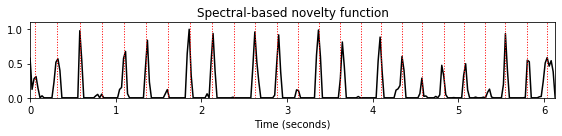

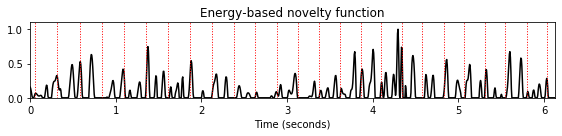

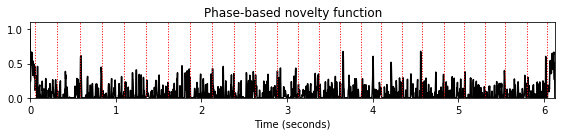

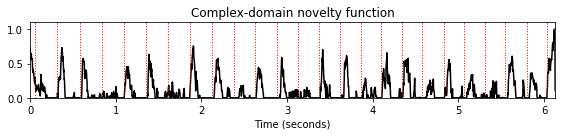

In [7]:
fn_ann = os.path.join('..', 'data', 'C6', 'FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.csv')
ann, label_keys = LibFMP.C6.read_annotation_pos(fn_ann, label='onset', header=0)

fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs)
x_duration = len(x)/Fs

N, H = 2048, 512
gamma = 10

figsize=(8,2)

nov, Fs_nov = LibFMP.C6.compute_novelty_spectrum(x, Fs=Fs, N=N, H=H, gamma=gamma)
fig, ax, line = LibFMP.B.plot_signal(nov, Fs_nov, figsize=figsize, color='k', 
    title='Spectral-based novelty function');
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                nontime_axis=True, time_min=0, time_max=x_duration);

nov, Fs_nov = LibFMP.C6.compute_novelty_energy(x, Fs=Fs, gamma=None)
fig, ax, line = LibFMP.B.plot_signal(nov, Fs_nov, figsize=figsize, color='k', 
    title='Energy-based novelty function');
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                nontime_axis=True, time_min=0, time_max=x_duration);

nov, Fs_nov = LibFMP.C6.compute_novelty_phase(x, Fs=Fs)
fig, ax, line = LibFMP.B.plot_signal(nov, Fs_nov, figsize=figsize, color='k', 
    title='Phase-based novelty function');
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                nontime_axis=True, time_min=0, time_max=x_duration);

nov, Fs_nov = LibFMP.C6.compute_novelty_complex(x, Fs=Fs)
fig, ax, line = LibFMP.B.plot_signal(nov, Fs_nov, figsize=figsize, color='k', 
    title='Complex-domain novelty function');
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                nontime_axis=True, time_min=0, time_max=x_duration);

## Further Notes

In this notebook, we have compared different novelty functions that are computed in conceptually different ways. The properties of a novelty function also crucially depend on the underlying parameters such as STFT parameters, window sizes for pre- and postprocessing, logarithmic compressions, and so on. Furthermore, in our implementation, we simply used differences between subsequent frames as a discrete approximation of the derivative. Here, one may apply **higher-order numerical differentiation** methods to better approximate the derivative. Besides the novelty function, subsequent processing steps such as [peak picking](../C6/C6S1_PeakPicking.html) may have a significant influence on the onset detection quality. Finally, in the implementation step, one needs to take care of normalization and padding conventions, which may lead to systematic differences and drifts.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Angel Villar-Corrales.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>